In [1]:
import matplotlib 
from matplotlib import cm
#permette di aprire le immagini in cartelle a parte, separate dal notebook
#matplotlib.use('Qt5Agg')

#import astropy
from scipy import odr
from pylab import *
from scipy.optimize import curve_fit
import sep
from astropy.io import fits
import matplotlib.pyplot as plt 
import numpy as np
from astropy.stats import sigma_clipped_stats
from astropy.modeling import models, fitting
from astropy import table
from astropy.table import QTable
import astropy.units as u
from astropy.io import ascii

from matplotlib.patches import Ellipse

from scipy.stats import chisquare

In [3]:
fit_riferimento = ascii.read('file:///data1/astlab04/SPS/6_filtri/MASS_SFR_tabs/Fit_RIFERIMENTOPlots/Fit_values.txt')
fit_no_ROSSI = ascii.read('file:///data1/astlab04/SPS/6_filtri/MASS_SFR_tabs/NO_ROSSIPlots/Fit_values.txt')
fit_no_BLU = ascii.read('file:///data1/astlab04/SPS/6_filtri/MASS_SFR_tabs/NO_U_IA484Plots/Fit_values.txt')

In [4]:
#mettere in ordine per lunghezza d'onda crescente
fit_vec = [fit_riferimento, fit_no_BLU, fit_no_ROSSI ]
sorg_vect = ['s10101','s12945','s13989','s15166','s15839','s2033','s2225', 's2236', 's23442', 's23669']
par_vect = ['TAU_50','AGE_50', 'AV_50', 'ALPHA_50', 'LMASS_50',  'AGE_GAS_50', 'ION_GAS_50', 'LSFR_50']

In [5]:
fit_riferimento

ID,TAU_16,TAU_50,TAU_84,AGE_16,AGE_50,AGE_84,AV_16,AV_50,AV_84,ALPHA_16,ALPHA_50,ALPHA_84,LMASS_16,LMASS_50,LMASS_84,AGE_GAS_16,AGE_GAS_50,AGE_GAS_84,ION_GAS_16,ION_GAS_50,ION_GAS_84,LSFR_16,LSFR_50,LSFR_84,LNZ,CHI2_PHOT
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10101,882.634,2570.071,11705.784,891.873,1085.112,2073.782,0.35,0.439,0.509,0.336,0.808,1.419,9.421,9.454,9.532,0.68,1.048,1.622,-3.322,-2.966,-2.497,0.228,0.228,0.32,237.227,31.059
12945,2259.912,2531.292,2819.32,6344.817,6686.886,6866.014,2.032,2.051,2.068,0.412,0.953,1.665,10.807,10.822,10.836,2.598,6.157,8.657,-3.503,-2.573,-1.524,0.305,0.305,0.374,230.191,11.121
13989,2688.528,3074.966,3574.858,5204.644,5730.486,6342.492,0.585,0.599,0.616,0.906,2.298,3.397,10.718,10.74,10.76,4.724,8.959,9.798,-3.934,-3.433,-2.322,0.521,0.521,0.535,15.366,78.58
15166,5958.319,11883.363,17304.366,426.038,486.249,566.325,0.976,1.003,1.026,2.513,3.108,3.708,9.594,9.621,9.645,6.584,8.339,9.537,-3.75,-3.122,-1.985,0.915,0.915,0.958,237.655,5.449
15839,5361.178,11152.669,16653.7,656.848,835.978,1060.835,0.292,0.34,0.393,0.78,1.969,3.312,9.095,9.14,9.182,0.805,1.488,4.273,-3.396,-2.862,-2.054,0.199,0.199,0.258,255.161,1.373
2033,310.155,335.285,402.767,5447.735,5544.988,5697.728,0.118,0.124,0.129,1.478,2.704,3.589,11.276,11.281,11.286,3.321,7.175,9.203,-3.67,-2.786,-1.609,-4.647,-4.647,-3.392,-707.776,318.795
2225,4359.509,8734.233,13891.463,107.414,123.668,145.576,1.754,1.786,1.821,0.604,1.37,2.788,9.396,9.416,9.441,7.206,8.147,9.174,-3.777,-3.466,-2.986,1.321,1.321,1.36,225.211,6.722
2236,7088.41,12585.99,17342.695,789.535,943.423,1114.394,0.205,0.237,0.271,0.788,2.108,3.303,9.466,9.5,9.526,4.562,7.546,9.165,-3.617,-2.736,-1.579,0.502,0.502,0.543,250.941,0.608
23442,5266.622,11507.435,17106.804,227.76,278.346,332.06,1.052,1.087,1.117,2.773,3.331,3.767,9.562,9.605,9.641,4.531,7.551,9.22,-3.664,-2.745,-1.602,1.162,1.162,1.198,240.816,3.739


In [6]:
#creo "matrice" a 3 entrate: la prima fissa la sorgente, dopodichè per ogni sorgente ho una tabella 
#con 8 parametri e 10 filtri (9 + quella di riferimento)


m_s = np.zeros([10,8,3])
for s in range (0,10): #sorgenti
    for i in range (0,3): #filtri: 0 = RIFERIMENTO, 1 = SOLO ROSSI, 2 = SOLO BLU (vd cavolo sotto)
        m_s[s,0,i] = fit_vec[i]['TAU_50'][s]
        m_s[s,1,i] = fit_vec[i]['AGE_50'][s]
        m_s[s,2,i] = fit_vec[i]['AV_50'][s]
        m_s[s,3,i] = fit_vec[i]['ALPHA_50'][s]
        m_s[s,4,i] = fit_vec[i]['LMASS_50'][s]
        m_s[s,5,i] = fit_vec[i]['AGE_GAS_50'][s]
        m_s[s,6,i] = fit_vec[i]['ION_GAS_50'][s]
        m_s[s,7,i] = fit_vec[i]['LSFR_50'][s]

In [7]:
########D'ORA IN AVANTI: SOLO ROSSI = no filtri blu (U,IA484). SOLO BLU = no filtri rossi (F160W, K, IRAC1, IRAC2)

cavolo = ['RIFERIMENTO','SOLO ROSSI','SOLO BLU'] 
err_abs = ['ERR_ABS_RIF', 'ERR_ABS_SOLO_ROSSI', 'ERR_ABS_SOLO_BLU']
err_rel = ['ERR_REL_RIF', 'ERR_REL_SOLO_ROSSI', 'ERR_REL_BLU']
z = [0.7281, 0.7393, 0.735, 0.7272, 0.7385, 0.728, 0.7281, 0.7287, 0.7307, 0.7499]


##creiamo una tabella per ogni parametro in cui abbiamo nelle righe le sorgenti con i valori dei parametri senza i
#vari filtri, una colonna con gli errori assoluti, una con gli errori relativi e una con 
#il rapporto degli errori relativi. Questo rapporto mi dà l'influenza del filtro nel ricavare quel parametro: se >1 
#domina il blu

for i in range (0,8):
    
    t = QTable(m_s[:,i,:], names = cavolo)  #trasforma matrice in tabella con header chiamata cavolo.
                                            #é una variabile interna al ciclo: non salviamo ogni tabella in un                                        
                                            #vettore, viene sovrascritta ad ogni iterazione
                                            
    
    if i == 4: #SELEZIONO PARAMETRO DELLA MASSA: log10 of the stellar mass (Msun)
        for u in range (0,3):
            t.add_column(table.Column(fit_vec[u]['LMASS_50'] + np.log10( (fit_vec[u]['LMASS_84']-fit_vec[u]['LMASS_16'])/2 )), name = err_abs[u])
            #t.add_column(table.Column((fit_vec[u]['LMASS_84']-fit_vec[u]['LMASS_16']) / (2*fit_vec[u]['LMASS_50']) )), name = err_rel[u])
        #t.add_column( table.Column( ( (fit_vec[1]['LMASS_84']-fit_vec[1]['LMASS_16']) / (2*fit_vec[1]['LMASS_50']) )/( (fit_vec[2]['LMASS_84']-fit_vec[2]['LMASS_16'])/(2*fit_vec[2]['LMASS_50']) ) ), name = 'err_R/err_B')         
    
    
    if i == 2: #SELEZIONO PARAMETRO DELLA DUST: dust attenuation in V-band (mag)
        for u in range (0,3):
            t.add_column(table.Column( (fit_vec[u]['AV_84']-fit_vec[u]['AV_16'])/2 ), name = err_abs[u])
            #t.add_column(table.Column( np.abs(  (fit_vec[u]['AV_84']-fit_vec[u]['AV_16']) / (2*fit_vec[u]['AV_50'])  ) ), name = err_rel[u])
        #t.add_column( table.Column( np.abs(  ( (fit_vec[1]['AV_84']-fit_vec[1]['AV_16']) / (2*fit_vec[1]['AV_50']) )/( (fit_vec[2]['AV_84']-fit_vec[2]['AV_16'])/(2*fit_vec[2]['AV_50']) )  ) ), name = 'err_R/err_B')
    
    
    if i == 7: #SELEZIONO PARAMETRO DELLA SFR: log10 of the star formation rate (Msun/yr)
        for u in range (0,3):
            t.add_column( table.Column(fit_vec[u]['LSFR_50'] + np.log10((fit_vec[u]['LSFR_84']-fit_vec[u]['LSFR_16'])/2 )), name = err_abs[u] )
            #t.add_column( table.Column( np.abs(  (fit_vec[u]['LSFR_84']-fit_vec[u]['LSFR_16']) / (2*fit_vec[u]['LSFR_50'])  ) ), name = err_rel[u] ) 
        #t.add_column( table.Column( np.abs(  ( (fit_vec[1]['LSFR_84']-fit_vec[1]['LSFR_16']) / (2*fit_vec[1]['LSFR_50']) )/( (fit_vec[2]['LSFR_84']-fit_vec[2]['LSFR_16'])/(2*fit_vec[2]['LSFR_50']) )  ) ), name = 'err_R/err_B') 
    
    t.add_column(table.Column(sorg_vect), name = 'Sorgente')
    t.add_column(table.Column(z), name = 'z')
    t.remove_row(5)
    t1 = fits.BinTableHDU(t) #converto la tebella in BinTable
    
    #t1.writeto(par_vect[i]+'errlog.fits') #salvo nella cartella di lavoro come file fits

In [8]:
t

RIFERIMENTO,SOLO ROSSI,SOLO BLU,ERR_ABS_RIF,ERR_ABS_SOLO_ROSSI,ERR_ABS_SOLO_BLU,Sorgente,z
float64,float64,float64,float64,float64,float64,str6,float64
0.228,0.09,0.399,-1.109242168318426,-1.1465720064370626,-0.8977086218813386,s10101,0.7281
0.305,0.215,0.267,-1.1571809049267259,-1.3007001606532138,-0.14305039867429226,s12945,0.7393
0.521,0.41,1.959,-1.6339019599857427,-1.2097887582883937,0.4775139398778865,s13989,0.735
0.915,0.473,1.123,-0.7525615400843955,-0.9706974992327123,-0.14864621797877153,s15166,0.7272
0.199,-0.012,0.158,-1.331177984021837,-1.1516619934290062,-1.3234860601221126,s15839,0.7385
1.321,0.436,1.013,-0.3889653886374804,-1.1407541260631924,0.14172228433842693,s2225,0.7281
0.502,0.188,0.396,-1.1862461389442454,-0.8012761346082269,-1.3609619513137057,s2236,0.7287
1.162,0.728,0.789,-0.5827274948966936,-0.5356034977233577,-0.7267001606532145,s23442,0.7307
0.087,0.24,0.644,-1.7369087409443187,-1.5047274948966936,-0.844116639021126,s23669,0.7499


In [30]:
tab_mass = fits.open('file:///data1/astlab04/MASS_SFR_tabs/LMASS_50.fits')
tab_sfr = fits.open('file:///data1/astlab04/MASS_SFR_tabs/LSFR_50.fits')

In [31]:
tab_sfr[1].data

FITS_rec([( 0.228,  0.09 , 0.399, 0.046 , 0.20175439, 0.058 , 0.64444444, 0.0505, 0.12656642,  5.09174917, 's10101', 0.7281),
          ( 0.305,  0.215, 0.267, 0.0345, 0.11311475, 0.0305, 0.14186047, 0.389 , 1.45692884,  0.09736952, 's12945', 0.7393),
          ( 0.521,  0.41 , 1.959, 0.007 , 0.0134357 , 0.024 , 0.05853659, 0.033 , 0.01684533,  3.47494457, 's13989', 0.735 ),
          ( 0.915,  0.473, 1.123, 0.0215, 0.02349727, 0.036 , 0.07610994, 0.0535, 0.04764025,  1.59759736, 's15166', 0.7272),
          ( 0.199, -0.012, 0.158, 0.0295, 0.14824121, 0.0725, 6.04166667, 0.033 , 0.20886076, 28.92676768, 's15839', 0.7385),
          (-4.647,  0.112, 2.571, 0.6275, 0.13503335, 0.002 , 0.01785714, 0.037 , 0.01439129,  1.24083012, 's2033', 0.728 ),
          ( 1.321,  0.436, 1.013, 0.0195, 0.01476154, 0.0265, 0.06077982, 0.1345, 0.13277394,  0.45776918, 's2225', 0.7281),
          ( 0.502,  0.188, 0.396, 0.0205, 0.04083665, 0.1025, 0.54521277, 0.0175, 0.04419192, 12.33738602, 's2236', 0.72

In [32]:
#plottiamo riferimenti vs i vari filtri
###Fittiamo i dati con una retta

def lineare(p,x):
    m, q = p
    y = m*x + q
    return y

#MASSA
#RIF vs BLU
quad_model1 = odr.Model(lineare)
data1 = odr.RealData(tab_mass[1].data['RIFERIMENTO'], 
                     tab_mass[1].data['SOLO BLU'],
                     sx = tab_mass[1].data['ERR_ABS_RIF'],
                     sy = tab_mass[1].data['ERR_ABS_SOLO_BLU']) 
odr1 = odr.ODR(data1, quad_model1, beta0 = [1.,0.])  
out1 = odr1.run()
print ('MASSA')
print ('BLU =', out1.beta)

#rif vs ROSSI
quad_model2 = odr.Model(lineare)
data2 = odr.RealData(tab_mass[1].data['RIFERIMENTO'], 
                     tab_mass[1].data['SOLO ROSSI'], 
                     sx = tab_mass[1].data['ERR_ABS_RIF'], 
                     sy = tab_mass[1].data['ERR_ABS_SOLO_ROSSI']) 
odr2 = odr.ODR(data2, quad_model2, beta0 = [1.,0.])
out2 = odr2.run()
print ('ROSSI =', out2.beta)


#STAR FORMATION RATE
#RIF vs BLU 
quad_model3 = odr.Model(lineare)
data3 = odr.RealData(tab_sfr[1].data['RIFERIMENTO'], 
                     tab_sfr[1].data['SOLO BLU'],
                     sx = tab_sfr[1].data['ERR_ABS_RIF'], 
                     sy = tab_sfr[1].data['ERR_ABS_SOLO_BLU']) 
odr3 = odr.ODR(data3, quad_model3, beta0 = [1.,0.]) 
out3 = odr3.run()
print ('\nSFR')
print ('BLU =', out3.beta)

 #rif vs ROSSI
quad_model4 = odr.Model(lineare)
data4 = odr.RealData(tab_sfr[1].data['RIFERIMENTO'], 
                     tab_sfr[1].data['SOLO ROSSI'], 
                     sx = tab_sfr[1].data['ERR_ABS_RIF'], 
                     sy = tab_sfr[1].data['ERR_ABS_SOLO_ROSSI'])
odr4 = odr.ODR(data4, quad_model4, beta0 = [1.,0.])
out4 = odr4.run()
print ('ROSSI =', out4.beta)


MASSA
BLU = [0.87705969 1.98812189]
ROSSI = [0.81086767 2.0860904 ]

SFR
BLU = [0.84807177 0.32653857]
ROSSI = [0.21269332 0.22504825]


In [33]:
########### CALCOLIAMO IL CHI QUADRO E IL P-VALUE PER OGNI FIT (TRA FIT E BISETTRICE)
#### MASSA
#RIF VS BLU
tt = np.linspace (9, 12, 10)
blu_m = (tt*out1.beta[0] + out1.beta[1])
chi_blu_m, p_blu_m = chisquare(blu_m, f_exp = tt)
print ('RIF VS BLU:\n', 'chi_2 = ',chi_blu_m ,'\n p_value = ', p_blu_m)

#RIF VS ROSSI
rosso_m = (tt*out2.beta[0] + out2.beta[1])
chi_rosso_m, p_rosso_m = chisquare(rosso_m, f_exp = tt)
print ('\nRIF VS ROSSO:\n', 'chi_2 = ',chi_rosso_m ,'\n p_value = ', p_rosso_m)


#### SFR
#RIF VS BLU
tv = np.linspace (0.01,2,10)
blu_sfr = (tv*out3.beta[0] + out3.beta[1])
chi_blu_sfr, p_blu_sfr = chisquare(blu_sfr, f_exp = tv)
print ('\nRIF VS BLU:\n', 'chi_2 = ',chi_blu_sfr ,'\n p_value = ', p_blu_sfr)

#RIF VS ROSSO
rosso_sfr = (tv*out4.beta[0] + out4.beta[1])
chi_rosso_sfr, p_rosso_sfr = chisquare(rosso_sfr, f_exp = tv)
print ('\nRIF VS ROSSO:\n', 'chi_2 = ',chi_rosso_sfr ,'\n p_value = ', p_rosso_sfr)

RIF VS BLU:
 chi_2 =  0.49477455993755204 
 p_value =  0.9999709098985937

RIF VS ROSSO:
 chi_2 =  0.04453944342209742 
 p_value =  0.9999999993114284

RIF VS BLU:
 chi_2 =  11.234289839420985 
 p_value =  0.25999086623288503

RIF VS ROSSO:
 chi_2 =  8.38312077220268 
 p_value =  0.4960448601137589


In [34]:
tv, blu_sfr

(array([0.01      , 0.23111111, 0.45222222, 0.67333333, 0.89444444,
        1.11555556, 1.33666667, 1.55777778, 1.77888889, 2.        ]),
 array([0.33501929, 0.52253738, 0.71005547, 0.89757356, 1.08509166,
        1.27260975, 1.46012784, 1.64764593, 1.83516403, 2.02268212]))

In [35]:
np.log10(0.005)

-2.3010299956639813

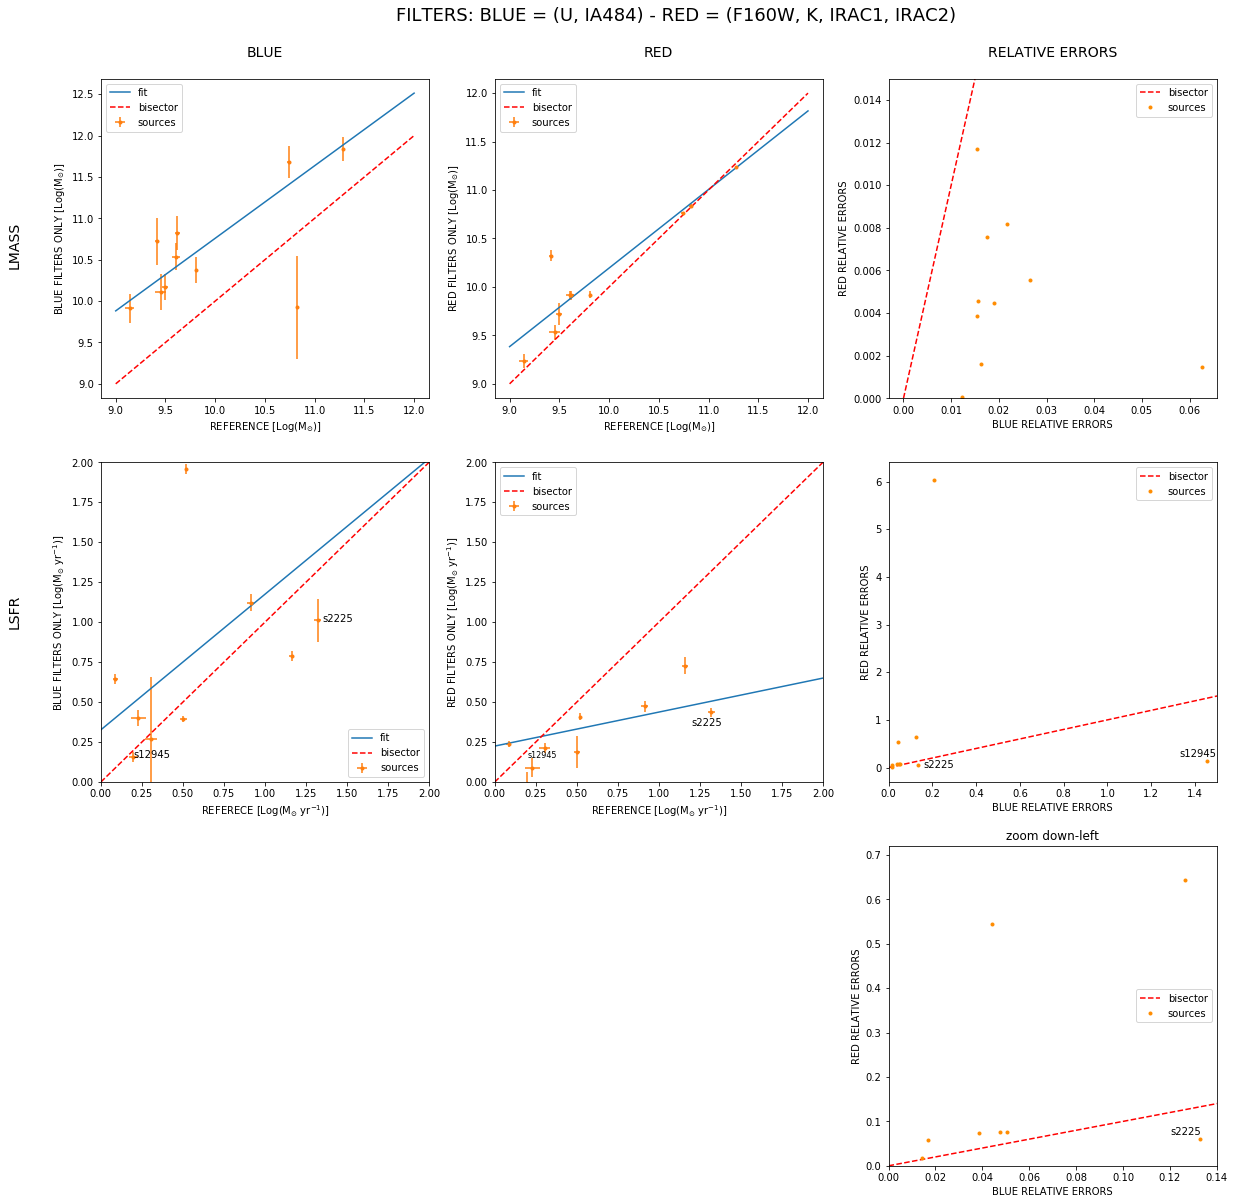

In [43]:
#%matplotlib notebook

fig = plt.figure( figsize = (20, 20))
figtext(0.33, 0.92, r'FILTERS: BLUE = (U, IA484) - RED = (F160W, K, IRAC1, IRAC2)', fontsize = 18 )
figtext(0.06, 0.75, 'LMASS', rotation = 'vertical', fontsize = 14)
figtext(0.06, 0.5, 'LSFR', rotation= 'vertical', fontsize = 14)



#####   MASSA
plt.subplot(3,3,1)
plt.title('BLUE\n', fontsize = 14)


#RETTE
x = np.linspace(9,12,10000)
plt.plot(x,x*out1.beta[0] + out1.beta[1], label = 'fit')
plt.plot(x,x, 'r', ls ='--', label = 'bisector')
#DATI
plt.errorbar(tab_mass[1].data['RIFERIMENTO'],
             tab_mass[1].data['SOLO BLU'],
             xerr= tab_mass[1].data['ERR_ABS_RIF'],
             yerr= tab_mass[1].data['ERR_ABS_SOLO_BLU'], 
             fmt='.', label = 'sources')
#STILE plt
plt.xlabel(r'REFERENCE [Log(M$_{\odot}$)]')
plt.ylabel(r'BLUE FILTERS ONLY [Log(M$_{\odot}$)]')
plt.legend(loc = 'best')


plt.subplot(3,3,2)
plt.title('RED\n', fontsize = 14)
#RETTE
plt.plot(x,x*out2.beta[0] + out2.beta[1], label = 'fit')
plt.plot(x, x, 'r', ls ='--', label = 'bisector')
#DATI
plt.errorbar(tab_mass[1].data['RIFERIMENTO'],
             tab_mass[1].data['SOLO ROSSI'],
             xerr= (tab_mass[1].data['ERR_ABS_RIF']), 
             yerr= (tab_mass[1].data['ERR_ABS_SOLO_ROSSI']),
             fmt='.', label = 'sources')
#STILE plt
plt.xlabel(r'REFERENCE [Log(M$_{\odot}$)]')
plt.ylabel(r'RED FILTERS ONLY [Log(M$_{\odot}$)]')
plt.legend(loc = 'best')




plt.subplot(3,3,3)
plt.title('RELATIVE ERRORS\n', fontsize = 14)

#RETTE
x3 = np.linspace(0,0.02,1000)
plt.plot(x3, x3, 'r', ls ='--', label = 'bisector')
#DATI
plt.errorbar(tab_mass[1].data['ERR_REL_BLU'],
             tab_mass[1].data['ERR_REL_SOLO_ROSSI'],
             c = 'darkorange', fmt='.', label = 'sources')
#STILE plt
plt.xlabel(r'BLUE RELATIVE ERRORS')
plt.ylabel(r'RED RELATIVE ERRORS')
#plt.xlim(0,0.02)
plt.ylim(0,0.015)
plt.legend(loc = 'best')


###### STAR FORMATION RATE ######
plt.subplot(3,3,4)

#RETTE
x1 = np.linspace(0,2,10000)
plt.plot(x1, x1*out3.beta[0] + out3.beta[1], label = 'fit')
plt.plot(x1, x1, 'r', ls ='--', label = 'bisector')
#DATI
plt.errorbar(tab_sfr[1].data['RIFERIMENTO'],
             tab_sfr[1].data['SOLO BLU'],
             xerr= tab_sfr[1].data['ERR_ABS_RIF'],
             yerr = tab_sfr[1].data['ERR_ABS_SOLO_BLU'], fmt='.',
             label = 'sources')
#STILE plt
plt.annotate(xy = (1.35,1), s = 's2225', fontsize = 10)
plt.annotate(xy = (0.2,0.15), s = 's12945', fontsize = 10)
plt.xlim(0,2.)
plt.ylim(0,2.)
plt.xlabel(r'REFERECE [Log(M$_{\odot}$ yr$^{-1}$)]')
plt.ylabel(r'BLUE FILTERS ONLY [Log(M$_{\odot}$ yr$^{-1}$)]')
plt.legend(loc = 'best')



plt.subplot(3,3,5)

#RETTE
plt.plot(x1, x1*out4.beta[0] + out4.beta[1], label = 'fit')
plt.plot(x1,x1, 'r', ls ='--', label = 'bisector')
#DATI
plt.errorbar(tab_sfr[1].data['RIFERIMENTO'], 
             tab_sfr[1].data['SOLO ROSSI'],
             xerr= tab_sfr[1].data['ERR_ABS_RIF'],
             yerr = tab_sfr[1].data['ERR_ABS_SOLO_ROSSI'],
             fmt='.', label = 'sources')
#STILE plt
plt.annotate(xy = (1.2,0.35), s = 's2225', fontsize = 10)
plt.annotate(xy = (0.2,0.15), s = 's12945', fontsize = 8)
#plt.xscale('Log')
#plt.yscale('Log')
plt.xlim(0,2.)
plt.ylim(0,2.)

plt.xlabel(r'REFERENCE [Log(M$_{\odot}$ yr$^{-1}$)]')
plt.ylabel(r'RED FILTERS ONLY [Log(M$_{\odot}$ yr$^{-1}$)]')
plt.legend(loc = 'best')


plt.subplot(3,3,6)


#RETTE
x4 = np.linspace(0,6.1,1000)
plt.plot(x4, x4, 'r', ls ='--', label = 'bisector')
#DATI
plt.errorbar(tab_sfr[1].data['ERR_REL_BLU'],
             tab_sfr[1].data['ERR_REL_SOLO_ROSSI'],
             c='darkorange', fmt='.', label = 'sources')
#STILE plt
plt.annotate(xy = (1.33, 0.22), s = 's12945', rotation = 0, fontsize = 10)
plt.annotate(xy = (0.16,0.0), s= 's2225')
plt.xlabel(r'BLUE RELATIVE ERRORS')
plt.ylabel(r'RED RELATIVE ERRORS')
plt.xlim(0,1.5)
#plt.ylim(0,.1)
plt.legend(loc = 'best')



plt.subplot(3,3,9)
plt.title('zoom down-left')

#RETTE
x4 = np.linspace(0,6.1,1000)
plt.plot(x4, x4, 'r', ls ='--', label = 'bisector')
#DATI
plt.errorbar(tab_sfr[1].data['ERR_REL_BLU'],
             tab_sfr[1].data['ERR_REL_SOLO_ROSSI'],
             c='darkorange', fmt='.', label = 'sources')
#STILE plt
plt.annotate(xy = (0.12,0.07), s= 's2225')
plt.xlabel(r'BLUE RELATIVE ERRORS')
plt.ylabel(r'RED RELATIVE ERRORS')
plt.xlim(0,0.14)
plt.ylim(0,0.72)
plt.legend(loc = 'best')



#plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
plt.savefig('mass_sfr.png')
plt.show()
